In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from os import listdir, path
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from glob import glob

In [2]:
def upload_image(path):
#     path = "train/"
    imlist = {}
    count = 0
    for each in glob(path + "*"):
        word = each.split("/")[-1]
        imlist[word] = []
        for imagefile in glob(path+word+"/*"):
            im = cv2.imread(imagefile, cv2.IMREAD_GRAYSCALE)
            imlist[word].append(im)
            count +=1 
            
    return [imlist,count]

def upload_image_V2():
    path = "train/Occupied"
    imlist = []
    count = 0
    for imagefile in glob(path+"/*"):
        im = cv2.imread(imagefile, 0)
        imlist.append(im)
        count +=1 
            
    return imlist,count

In [3]:
sift_object = cv2.xfeatures2d.SIFT_create()
def features(image):
    keypoints, descriptors = sift_object.detectAndCompute(image, None)
    return [keypoints, descriptors]

In [4]:
def formatND(l):
    vStack = np.array(l[0])
    for remaining in l[1:]:
        vStack = np.vstack((vStack, remaining))
    return vStack

In [5]:
def developVocabulary(n_images, descriptor_list,n_clusters,kmeans_ret):
    mega_histogram = np.array([np.zeros(n_clusters) for i in range(n_images)])
    old_count = 0
    for i in range(n_images):
        l = len(descriptor_list[i])
        for j in range(l):
            if kmeans_ret is None:
                idx = kmeans_ret[old_count+j]
            else:
                idx = kmeans_ret[old_count+j]
            mega_histogram[i][idx] += 1
        old_count += l
    return mega_histogram

In [6]:
clf  = SVC()
def train(train_labels,mega_hist):
    print ("Training SVM")
    print (clf)
    print ("Train labels", train_labels)
    clf.fit(mega_hist, train_labels)

In [48]:
no_clusters = 100
trainImageCount = 0
train_labels = np.array([])
descriptor_list = []
name_dict = {}

[imgs,count] = upload_image('train/')
words = list(imgs.keys())
img_list = list(imgs.values())
label_count = 0 
for i in range(len(words)):
    name_dict[str(label_count)] = words[i]
    for img in img_list[1]:
            train_labels = np.append(train_labels, label_count)
            kp, des = features(img)
            if des is None:
                des = np.zeros((1,128))
            descriptor_list.append(des)
    label_count += 1


In [20]:
descriptor_stack = formatND(descriptor_list)

In [21]:
kmeans_obj = KMeans(n_clusters = no_clusters)
kmeans_ret = None
kmeans_ret = kmeans_obj.fit_predict(descriptor_stack)

In [22]:
mega_hist = developVocabulary(count, descriptor_list,no_clusters,kmeans_ret)

Plotting histogram
[ 846  928  702  924  740 1112  376  530  666  484  844 1332 1116 1018 1116
  750 1178 1384 1040  812 1084  436  636  598 1320  608  826  490 1222  856
  550  478  690  798  816 1468  688  556  902  778  568  710  688 1600  430
 1228  604  766  588  570  696  466 2058  770  616  740  932  656  548  616
  438  494  472  720  478 1248  828 1212  774  736 1018  598  366  476  920
  648  596  690  802  474  826  840  628  822  950  602  646  400  520  428
 1070  828  642  736  688  944  750  590  488  762]


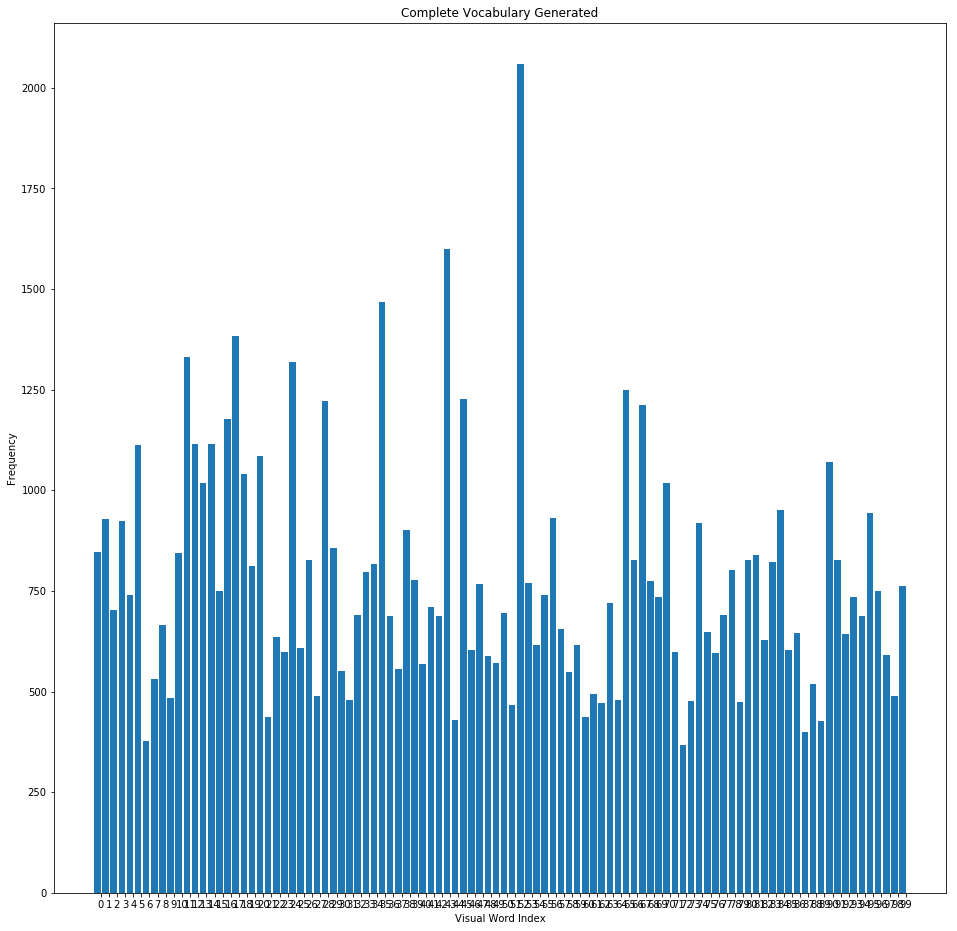

In [23]:
print("Plotting histogram")

vocabulary = mega_hist

x_scalar = np.arange(no_clusters)
y_scalar = np.array([abs(np.sum(vocabulary[:,h], dtype=np.int32)) for h in range(no_clusters)])

print (y_scalar)
plt.figure(figsize=(16,16))
plt.bar(x_scalar, y_scalar)
plt.xlabel("Visual Word Index")
plt.ylabel("Frequency")
plt.title("Complete Vocabulary Generated")
plt.xticks(x_scalar + 0.4, x_scalar)
plt.show()

In [24]:
scale = StandardScaler().fit(mega_hist)
mega_hist = scale.transform(mega_hist)

In [25]:
train(train_labels,mega_hist)

Training SVM
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Train labels [ 0.  0.  0. ...,  1.  1.  1.]


In [30]:
def recognize(img,no_clusters):
    kp, des = features(img)
    vocab = np.array( [[ 0 for i in range(no_clusters)]])
    if des is None:
        des = np.zeros((1,128))    
    test_ret = kmeans_obj.predict(des)
    for each in test_ret:
            vocab[0][each] += 1
    vocab = scale.transform(vocab)
    lb = clf.predict(vocab)
    return lb

In [40]:
test_imgs, test_count = upload_image('test/')

predictions = []
words = list(test_imgs.keys())
img_list = list(test_imgs.values())
for i in range(len(words)):
    print ("processing " ,words[i])
    for im in img_list[i]:
        cl = recognize(im,no_clusters)
#         print cl
        predictions.append({
            'image':im,
            'class':cl,
            'object_name':name_dict[str(int(cl[0]))]
            })


processing  Occupied


/home/sebasmeh/cv/local/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


processing  Empty


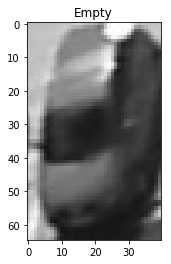

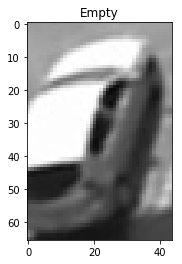

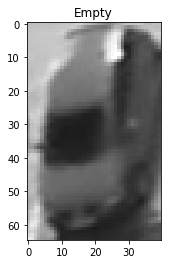

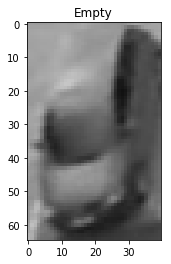

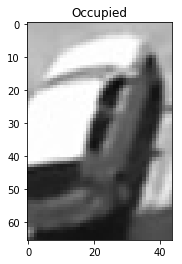

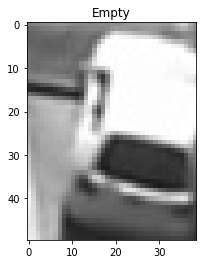

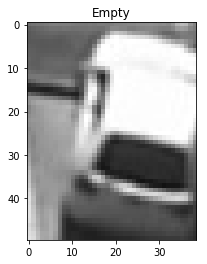

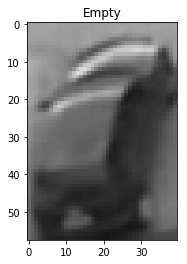

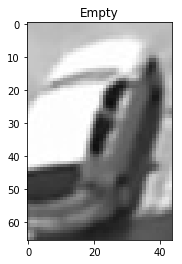

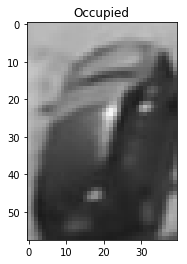

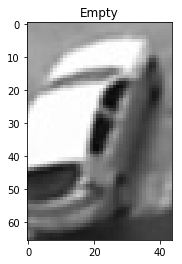

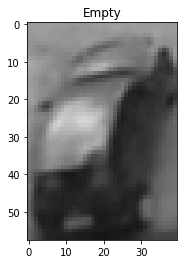

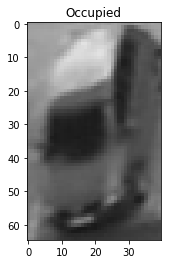

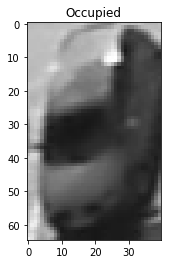

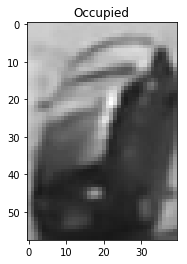

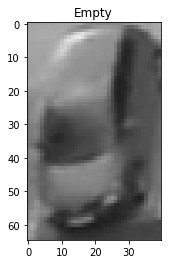

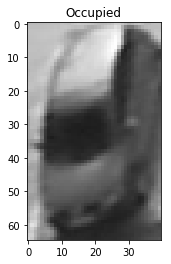

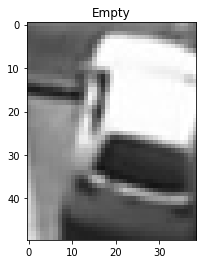

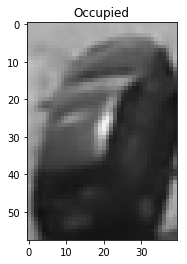

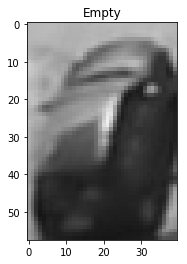

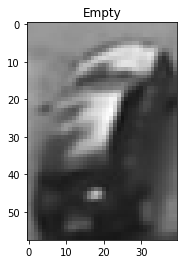

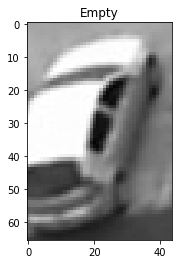

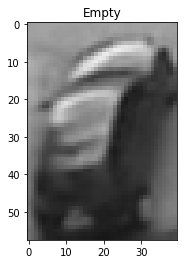

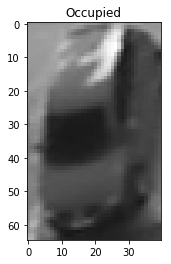

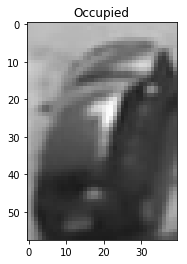

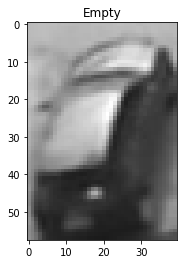

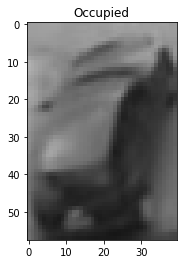

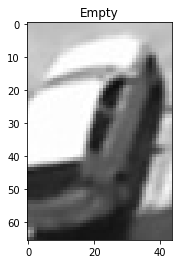

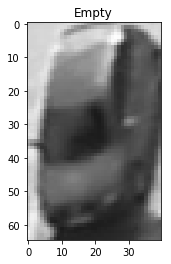

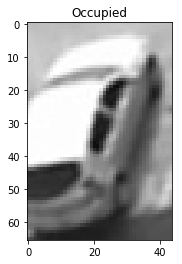

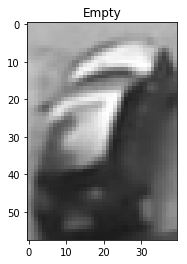

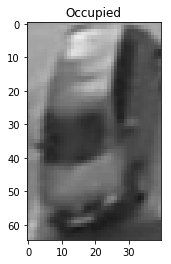

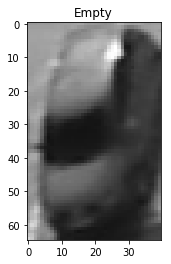

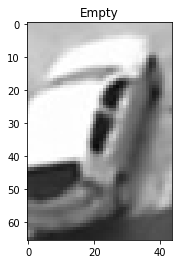

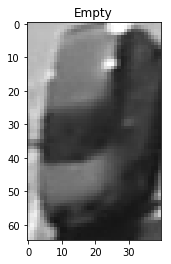

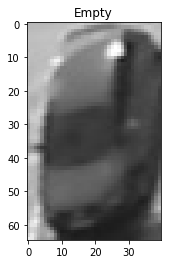

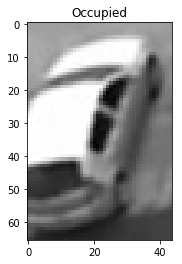

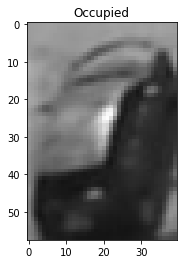

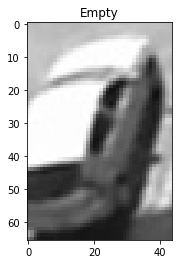

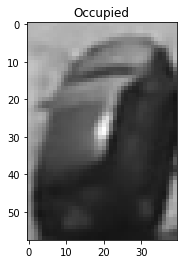

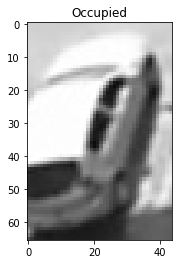

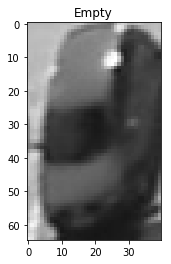

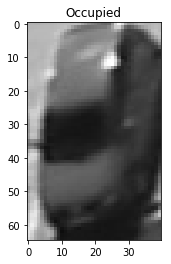

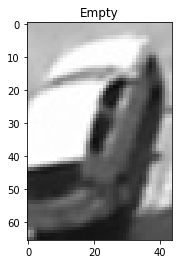

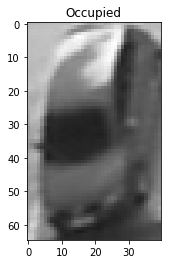

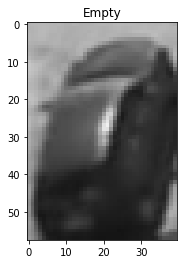

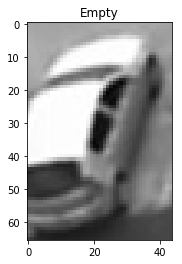

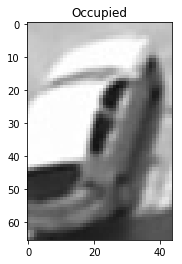

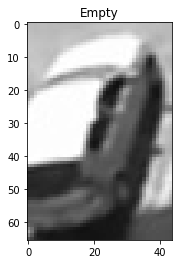

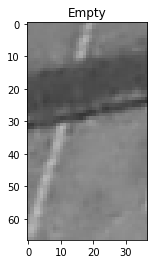

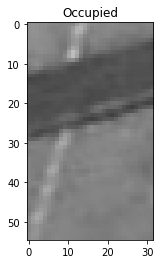

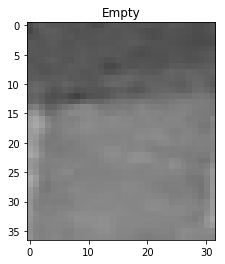

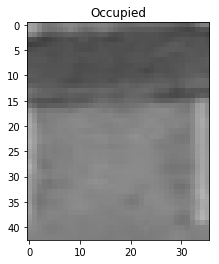

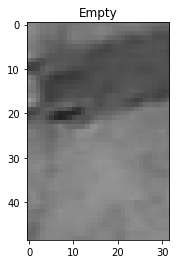

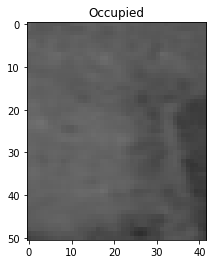

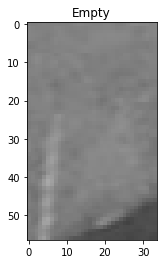

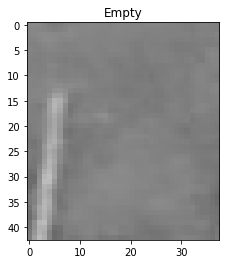

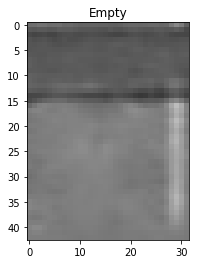

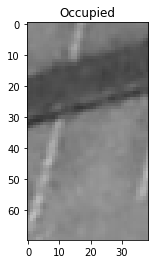

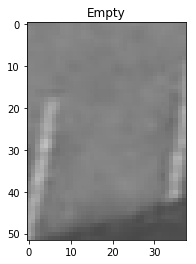

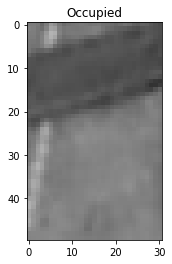

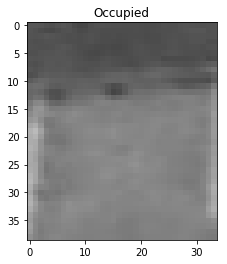

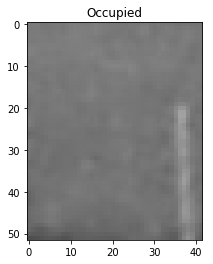

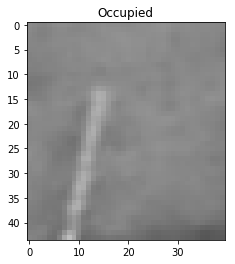

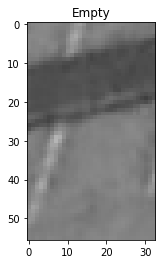

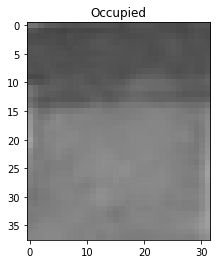

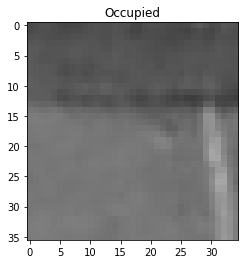

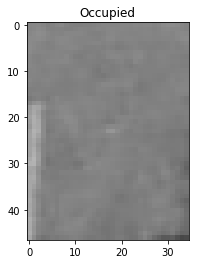

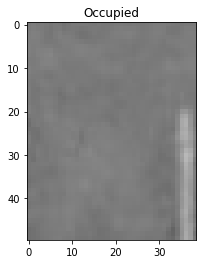

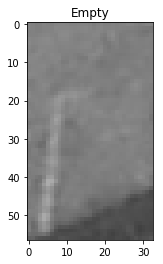

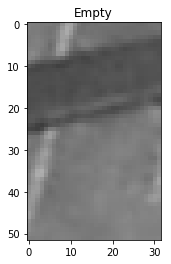

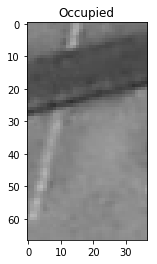

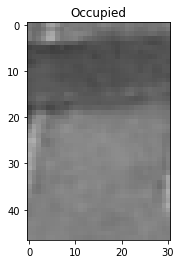

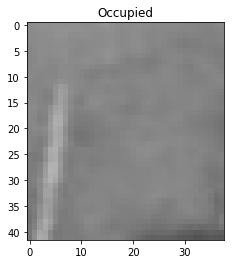

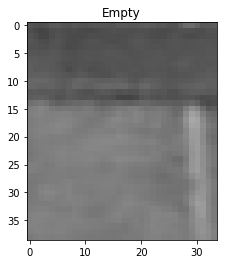

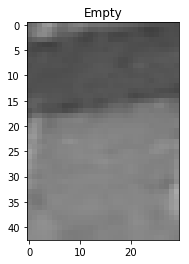

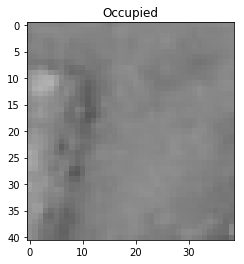

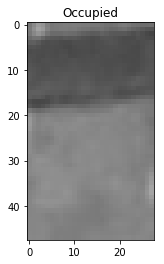

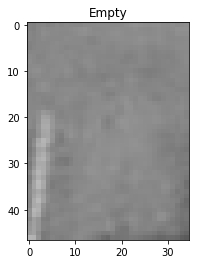

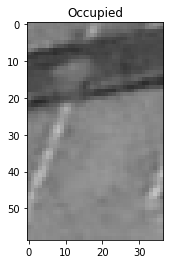

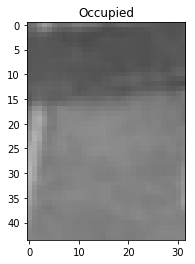

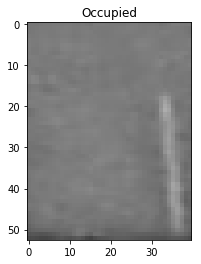

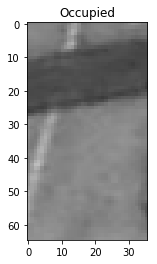

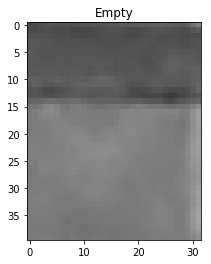

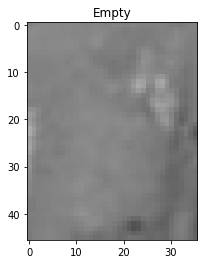

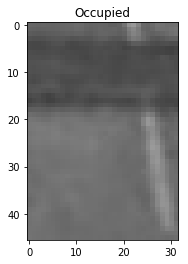

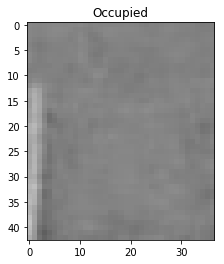

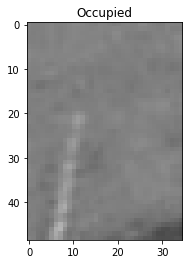

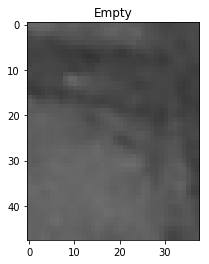

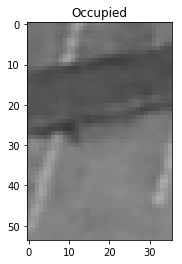

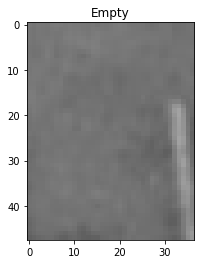

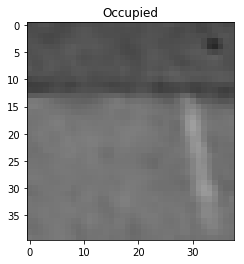

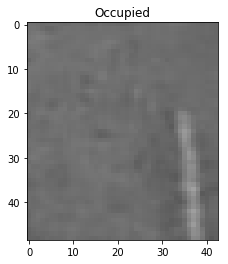

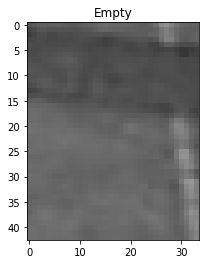

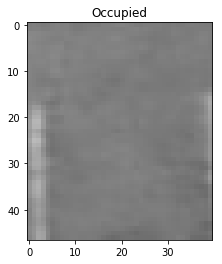

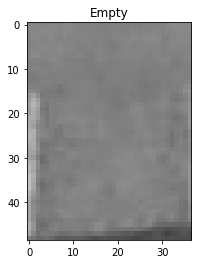

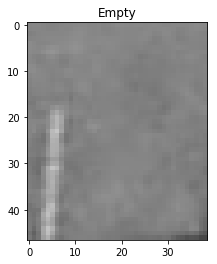

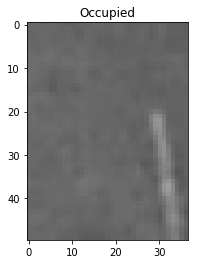

In [41]:
for each in predictions:
    plt.imshow(cv2.cvtColor(each['image'], cv2.COLOR_GRAY2RGB))
    plt.title(each['object_name'])
    plt.show()